In [1]:
from sklearn.datasets import load_boston
import pandas as pd
from pylab import rcParams #нужно для запуска команды для увеличения размера графиков
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
rcParams['figure.figsize'] = 13,6 #увеличиваем размер графиков

In [3]:
pd.set_option('display.max_rows', 500)#увеличиваем размер отображаемого Data Frame в окне  (чтобы не было сокращений)

In [22]:
boston = pd.read_csv(load_boston()['filename'], skiprows=1)
# Переменная, которую надо предсказать - ’MEDV’.
# Прочитать информацию о содержимом датасета:
print(load_boston()['DESCR'])
boston.head()

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


Проверим на наличие выбросов целевую колонку:

{'whiskers': [<matplotlib.lines.Line2D at 0x1bde18ccdc0>,
 'caps': [<matplotlib.lines.Line2D at 0x1bde195adc0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1bde18cc550>],
 'medians': [<matplotlib.lines.Line2D at 0x1bde18df940>],
 'fliers': [<matplotlib.lines.Line2D at 0x1bde18df7f0>],
 'means': []}

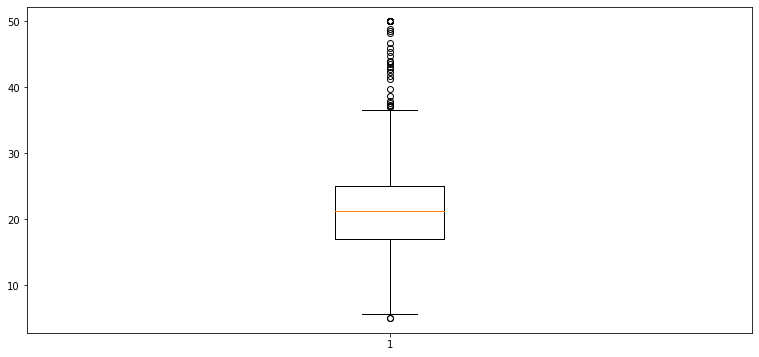

In [24]:
plt.boxplot(boston['MEDV'])

Выбросов не наблюдается. Все нормально

Попробуем помотреть на heatmap, вдруг есть зависимости...


<AxesSubplot:>

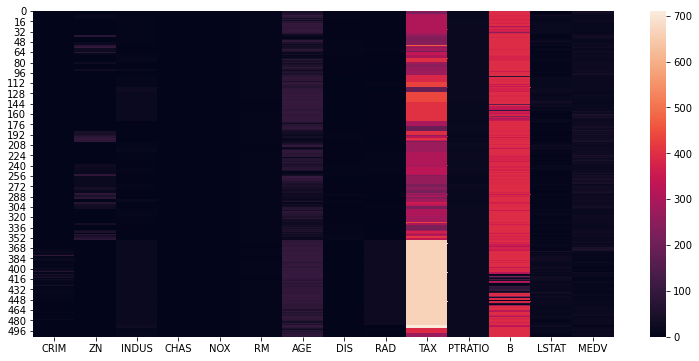

In [11]:
sns.heatmap(data=boston)

не помогло, пойдем другим путем (да, не спорю, погуглил)

<AxesSubplot:>

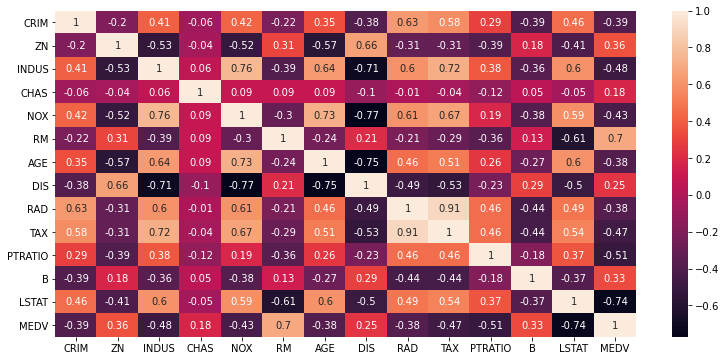

In [5]:
correlation_matrix = boston.corr().round(2)

sns.heatmap(data=correlation_matrix, annot=True) # annot = True - для описания значений внутри квадратов

Видим, что есть неплохие зависимости между MEDV и LSTAT, а также RM и PTRATIO
Но PTRATIO и LSTAT имеют отрицательную зависимость, в то время, как RM имеет положительную. Ради интереса попробуем добавить столбцы с инвертированными значениями и сравнить их с оригинальными по качеству модели

In [6]:
boston['LSTAT_inv'] = boston['LSTAT'] * -1
boston['PTRATIO_inv'] = boston['PTRATIO'] * -1

<AxesSubplot:xlabel='PTRATIO_inv', ylabel='MEDV'>

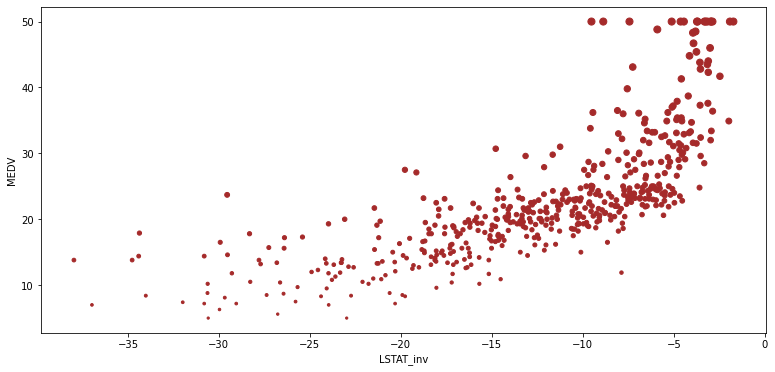

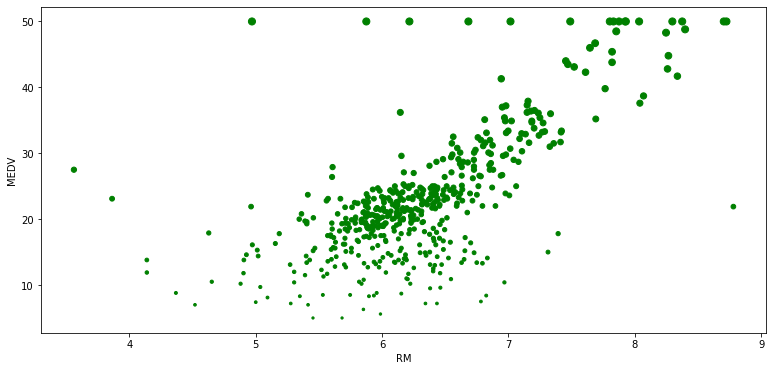

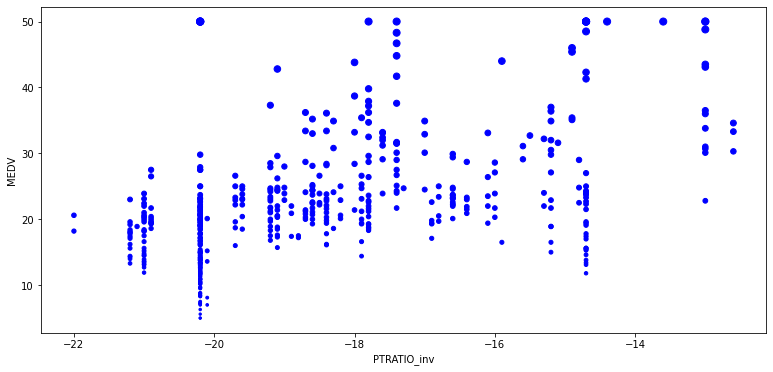

In [8]:
boston.plot(kind='scatter',
                 x='LSTAT_inv',
                 y='MEDV',
         s=boston['MEDV'],
         color='brown')
boston.plot(kind='scatter',
                 x='RM',
                 y='MEDV',
         s=boston['MEDV'],
         color='green')
boston.plot(kind='scatter',
                 x='PTRATIO_inv',
                 y='MEDV',
         s=boston['MEDV'],
         color='blue')

In [9]:
X = boston[['LSTAT_inv','RM', 'PTRATIO_inv']]
Y = boston['MEDV']

In [10]:
def get_score(X,y, random_seed=42, model=None):
  if model is None:
    model = LinearRegression()
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed )  
  model.fit(X_train, y_train)
  return model.score(X_test, y_test)

In [12]:
get_score(X,Y)

0.650904156861472

In [15]:
X_o = boston[['LSTAT','RM', 'PTRATIO']]
Y_o = boston['MEDV']

In [17]:
get_score(X_o,Y_o)

0.650904156861472

Никаких изменений не произошло (что вполне логично, но было интересно)

А теперь попробуем включить все столбцы в X, как они есть протестировать качество модели:

In [19]:
X_full = boston.drop(['MEDV'], axis=1)

In [21]:
get_score(X_full,Y)

0.7112260057484909

А самое интересное, что простое включение всех колонок без лишних заморочек дает большее качество модели, чем включение только тех, у которых высокая корреляция с целевой

Далее я так же пробовал стандартизировать данные с помощью cstandart scaler, но ничего хорошего не плучилось (качество модели упало до 63%), так что сюда я это даже включать не буду.
Прогресс наступил, когда я попробовал применить метод One Hot

In [40]:
def get_one_hot(X, cols):
    for each in cols:
        dummies = pd.get_dummies(X[each], prefix=each, drop_first=False)
        X = pd.concat([X, dummies], axis=1)
    return X


In [27]:
X_hot = get_one_hot(X, X)
X_hot.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,...,PTRATIO_inv_-15.3,PTRATIO_inv_-15.2,PTRATIO_inv_-15.1,PTRATIO_inv_-14.9,PTRATIO_inv_-14.8,PTRATIO_inv_-14.7,PTRATIO_inv_-14.4,PTRATIO_inv_-13.6,PTRATIO_inv_-13.0,PTRATIO_inv_-12.6
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,...,1,0,0,0,0,0,0,0,0,0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,...,0,0,0,0,0,0,0,0,0,0
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,...,0,0,0,0,0,0,0,0,0,0
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,...,0,0,0,0,0,0,0,0,0,0
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,...,0,0,0,0,0,0,0,0,0,0


In [28]:
get_score(X_hot,Y)

0.788341517046868

In [ ]:
Вот этот показатель меня уже устраивает.